In [1]:
%load_ext autoreload
%autoreload 2
import copy
import torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro import poutine, infer, nn, optim, distributions as dist
plt.style.use('seaborn-v0_8')

/env_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(100)
x = torch.empty(100).uniform_(-10., 10)
w = torch.randn(1)
y = w * x +  torch.empty(100).uniform_(-1, 1) * torch.normal(torch.zeros(100), torch.tensor(1.0))
y

tensor([-2.4971,  2.2829, -0.9769,  0.4526,  1.7674,  0.9741, -1.0203, -2.1984,
        -1.3567, -2.7728, -1.8361,  1.8149,  1.0362,  0.9770, -0.3284,  1.8458,
         1.5876,  0.5422, -1.4268, -0.3969, -1.2571,  2.0853,  0.2670,  2.5184,
        -0.4065,  2.3344,  0.9423, -0.2181, -0.7562,  1.0737,  0.2526, -0.6081,
         0.1217, -0.3495, -2.1891, -1.6709,  2.5064, -0.2559, -2.3143,  1.8706,
         0.2763, -2.2526,  0.6672, -0.7031, -0.7695, -0.4154, -2.1949,  0.0344,
         1.7918,  0.5410, -1.3674,  2.0369, -0.2893, -0.6131,  0.8173,  0.1390,
         0.6829,  0.1947,  2.0656,  1.1545, -0.8845,  1.1241, -2.0890,  1.7142,
         1.6274,  1.1466,  1.4236,  0.7611, -0.9068, -0.3946,  1.2722,  1.2008,
        -2.2236,  1.0281, -1.1827, -2.5624,  2.2250,  1.1160,  1.7990, -0.0313,
        -2.0498,  2.5113, -1.2418, -2.5171,  2.5265, -1.1090, -0.9411,  2.2015,
         0.2584, -2.2697, -0.2557, -1.8052,  2.2701, -2.4153, -1.7193, -0.9829,
        -1.8615,  2.0312, -1.2797, -0.81

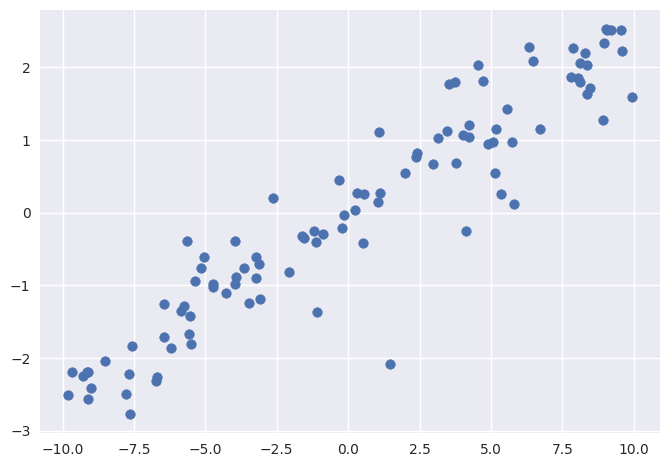

In [3]:
plt.scatter(x.flatten(), y.flatten(), )

In [4]:
data = {"x": x, "y": y}

In [5]:
data["x"]

tensor([-7.7667,  6.3169, -4.7488, -0.3224,  3.5301,  5.0782, -4.7462, -9.1432,
        -5.8394, -7.6393, -7.5661,  4.7120,  4.2353,  5.7516, -1.6339,  8.0283,
         9.9377,  5.1303, -5.5221, -3.9531, -6.4316,  6.4769,  1.1149,  9.5405,
        -1.1195,  8.9569,  4.8897, -0.2160, -5.1488,  4.0068,  0.5538, -5.0563,
         5.8177, -1.5303, -9.6620, -5.5821,  9.0707,  4.1281, -6.7424,  7.8040,
         0.3254, -9.2823,  2.9527, -3.1395, -3.6352,  0.5218, -9.1068,  0.2470,
         8.1015,  1.9771, -1.0999,  4.5566, -0.8748, -3.2227,  2.4229,  1.0603,
         3.7921, -2.6253,  8.1054,  6.7115, -3.9219,  3.4525,  1.4793,  8.4659,
         8.3562,  5.1805,  5.5504,  2.3575, -3.2426, -5.6594,  8.9072,  4.2312,
        -7.6852,  3.1472, -3.0970, -9.0931,  9.5952,  1.0958,  3.7357, -0.1592,
        -8.5040,  9.2097, -3.4582, -9.7949,  9.0320, -4.2895, -5.3517,  8.2818,
         5.3361, -6.6816, -1.2134, -5.5143,  7.8697, -9.0051, -6.4404, -3.9781,
        -6.2141,  8.3720, -5.7371, -2.08

In [6]:
data["y"]

tensor([-2.4971,  2.2829, -0.9769,  0.4526,  1.7674,  0.9741, -1.0203, -2.1984,
        -1.3567, -2.7728, -1.8361,  1.8149,  1.0362,  0.9770, -0.3284,  1.8458,
         1.5876,  0.5422, -1.4268, -0.3969, -1.2571,  2.0853,  0.2670,  2.5184,
        -0.4065,  2.3344,  0.9423, -0.2181, -0.7562,  1.0737,  0.2526, -0.6081,
         0.1217, -0.3495, -2.1891, -1.6709,  2.5064, -0.2559, -2.3143,  1.8706,
         0.2763, -2.2526,  0.6672, -0.7031, -0.7695, -0.4154, -2.1949,  0.0344,
         1.7918,  0.5410, -1.3674,  2.0369, -0.2893, -0.6131,  0.8173,  0.1390,
         0.6829,  0.1947,  2.0656,  1.1545, -0.8845,  1.1241, -2.0890,  1.7142,
         1.6274,  1.1466,  1.4236,  0.7611, -0.9068, -0.3946,  1.2722,  1.2008,
        -2.2236,  1.0281, -1.1827, -2.5624,  2.2250,  1.1160,  1.7990, -0.0313,
        -2.0498,  2.5113, -1.2418, -2.5171,  2.5265, -1.1090, -0.9411,  2.2015,
         0.2584, -2.2697, -0.2557, -1.8052,  2.2701, -2.4153, -1.7193, -0.9829,
        -1.8615,  2.0312, -1.2797, -0.81

In [7]:
w

tensor([0.2437])

In [8]:
param_store = pyro.get_param_store()

In [9]:
param_store

## Linear Regression

In [10]:
def linear_reg_model(data):
    lin_w = pyro.param("lin_w", lambda: torch.tensor(1.0))
    with pyro.plate("data", len(data['x'])):
        mu = lin_w * data["x"]
        sub_data = pyro.sample("yhat", dist.Normal(mu, 
                                                   torch.tensor(1.)), 
                               obs=data["y"]
                               )
    return sub_data

def linear_reg_guide(data):
    pass



In [11]:
pyro.clear_param_store()
pyro.set_rng_seed(0)
opt = optim.Adam({"lr": 1e-3})
svi = SVI(linear_reg_model, linear_reg_guide, opt, Trace_ELBO())

losses = []
for i in range(1000):
    losses.append(svi.step(data))
    

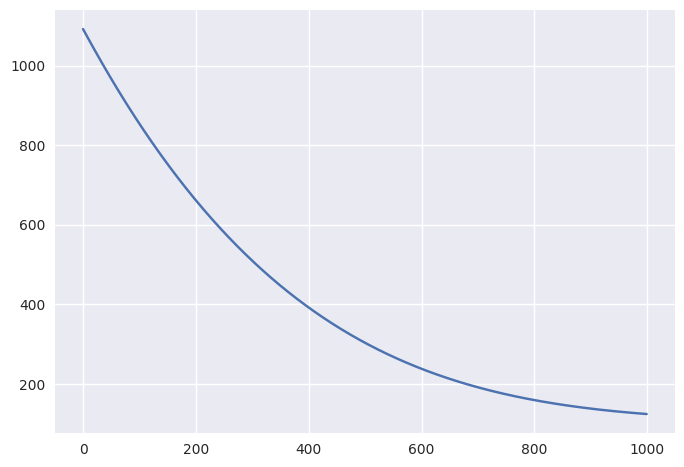

In [12]:
plt.plot(losses)

In [13]:
list(param_store.items())

[('lin_w', tensor(0.3481, requires_grad=True))]

In [14]:
pyro.param("lin_w")

tensor(0.3481, requires_grad=True)

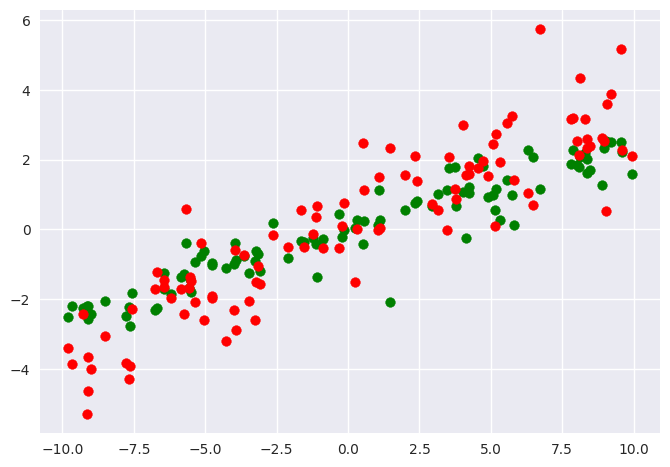

In [15]:
d = copy.deepcopy(data)
d["y"] = None
fig, ax = plt.subplots()
ax.scatter(data["x"], data["y"], color="g")
ax.scatter(data["x"], linear_reg_model(d).detach().numpy(), color="r", label="Predicted")

In [16]:
def linear_reg_map_model(data):
    lin_w = pyro.param("lin_w", lambda: torch.tensor(1.0))
    with pyro.plate("data", len(data['x'])):
        mu = lin_w * data["x"]
        sub_data = pyro.sample("yhat", dist.Normal(mu, 
                                                   torch.tensor(1.)), 
                               obs=data["y"]
                               )
    return sub_data


In [17]:
pyro.clear_param_store()
pyro.set_rng_seed(0)
opt = optim.Adam({"lr": 1e-3})
svi = SVI(linear_reg_map_model, infer.autoguide.AutoNormal(linear_reg_map_model), 
          opt, 
          Trace_ELBO()
          )

losses = []
for i in range(1000):
    losses.append(svi.step(data))
    

In [18]:
list(param_store.items())

[('lin_w', tensor(0.3481, requires_grad=True))]

In [19]:
def linear_reg_map_model(data):
    lin_w = pyro.sample("lin_w", dist.Normal(torch.tensor(0.), torch.tensor(10.0)))
    with pyro.plate("data", len(data['x'])):
        mu = lin_w * data["x"]
        sub_data = pyro.sample("yhat", dist.Normal(mu, 
                                                   torch.tensor(1.)), 
                               obs=data["y"]
                               )
    return sub_data

pyro.clear_param_store()
pyro.set_rng_seed(0)
opt = optim.Adam({"lr": 1e-3})
svi = SVI(linear_reg_map_model, infer.autoguide.AutoNormal(linear_reg_map_model), 
          opt, 
          Trace_ELBO()
          )

losses = []
for i in range(1000):
    losses.append(svi.step(data))

In [20]:
list(param_store.items())

[('AutoNormal.locs.lin_w',
  Parameter containing:
  tensor(0.2418, requires_grad=True)),
 ('AutoNormal.scales.lin_w', tensor(0.0694, grad_fn=<SoftplusBackward0>))]

In [21]:
param_store['AutoNormal.locs.lin_w']

Parameter containing:
tensor(0.2418, requires_grad=True)

In [22]:
param_store['AutoNormal.scales.lin_w']

tensor(0.0694, grad_fn=<SoftplusBackward0>)

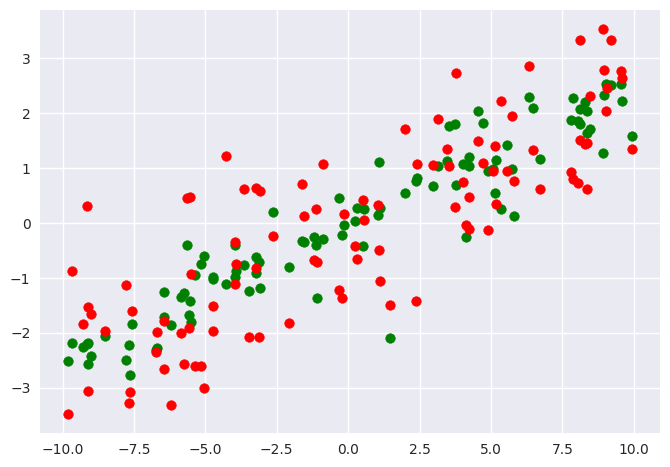

In [23]:
d = copy.deepcopy(data)
d["y"] = None

pred = infer.Predictive(svi.model, guide=svi.guide, num_samples=1)
fig, ax = plt.subplots()

ax.scatter(data["x"], data["y"], color="g")
ax.scatter(data["x"], pred(d)["yhat"].detach().numpy(), color="r", label="Predicted")

In [24]:
m = nn.PyroModule()

In [25]:
list(param_store.keys())

['AutoNormal.locs.lin_w', 'AutoNormal.scales.lin_w']

In [26]:
m.w = nn.PyroParam(lambda: torch.randn(1))

In [27]:
list(param_store.keys())

['AutoNormal.locs.lin_w', 'AutoNormal.scales.lin_w']

In [29]:
list(m.parameters())

[Parameter containing:
 tensor([0.5425], requires_grad=True)]

In [42]:
pyro.clear_param_store()
pyro.set_rng_seed(0)
m = nn.PyroModule()
m.w = nn.PyroParam(lambda: torch.randn(1))
pyro.module("m", m)
print(m.w.data)
def linear_reg_module_model(data):
    with pyro.plate("data", len(data['x'])):
        mu = m.w * data["x"]
        sub_data = pyro.sample("yhat", dist.Normal(mu, 
                                                   torch.tensor(1.)), 
                               obs=data["y"]
                               )
    return sub_data
opt = optim.Adam({"lr": 1e-3})
svi = SVI(linear_reg_module_model, 
          lambda d: None, 
          opt, 
          Trace_ELBO()
          )

losses = []
for i in range(1000):
    losses.append(svi.step(data))

tensor([1.5410])


In [43]:
list(m.parameters())

[Parameter containing:
 tensor([1.5410], requires_grad=True)]

In [44]:
list(m.parameters())

[Parameter containing:
 tensor([1.5410], requires_grad=True)]

tensor([1.5410])


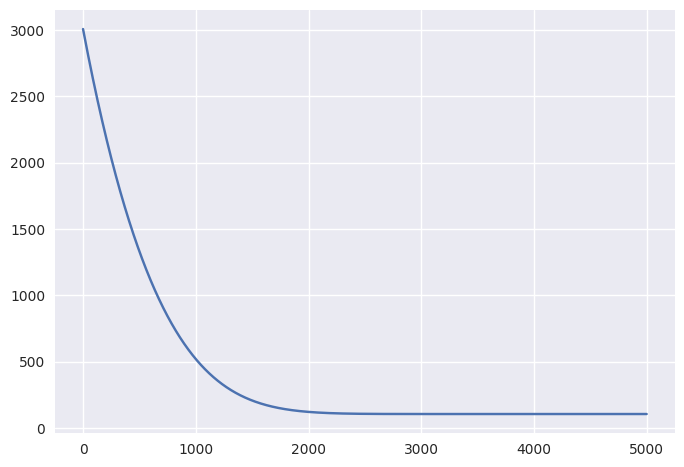

In [34]:
pyro.clear_param_store()
pyro.set_rng_seed(0)
m = nn.PyroModule()

m.w = nn.PyroParam(torch.randn(1))
print(m.w.data)

def linear_reg_module_model(data):
    pyro.module("m", m)
    with pyro.plate("data", len(data['x'])):
        mu = m.w * data["x"]
        sub_data = pyro.sample("yhat", dist.Normal(mu, 
                                                   torch.tensor(1.)), 
                               obs=data["y"]
                               )
    return sub_data
opt = optim.Adam({"lr": 1e-3})
svi = SVI(linear_reg_module_model, 
          lambda d: None, 
          opt, 
          Trace_ELBO()
          )

losses = []
for i in range(5000):
    losses.append(svi.step(data))
    
plt.plot(losses)

In [39]:
list(m.parameters())

[Parameter containing:
 tensor([0.2430], requires_grad=True)]

In [40]:
[(p[0], p[1].unconstrained()) for p in param_store.named_parameters()]

[('m$$$w_unconstrained',
  Parameter containing:
  tensor([0.2430], requires_grad=True))]

In [41]:
param_store['m$$$w_unconstrained']

Parameter containing:
tensor([0.2430], requires_grad=True)

In [45]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

m = nn.PyroModule("m")
m.w = nn.PyroSample(dist.Normal(0, 10.))
print(m.w.data)

def linear_reg_module_model(data):
    pyro.module("m", m)
    with pyro.plate("data", len(data['x'])):
        mu = m.w * data["x"]
        sub_data = pyro.sample("yhat", dist.Normal(mu, 
                                                   torch.tensor(1.)), 
                               obs=data["y"]
                               )
    return sub_data


opt = optim.Adam({"lr": 1e-3})
svi = SVI(linear_reg_module_model, 
          lambda d: None, 
          opt, 
          Trace_ELBO()
          )

losses = []
for i in range(5000):
    losses.append(svi.step(data))

tensor(15.4100)


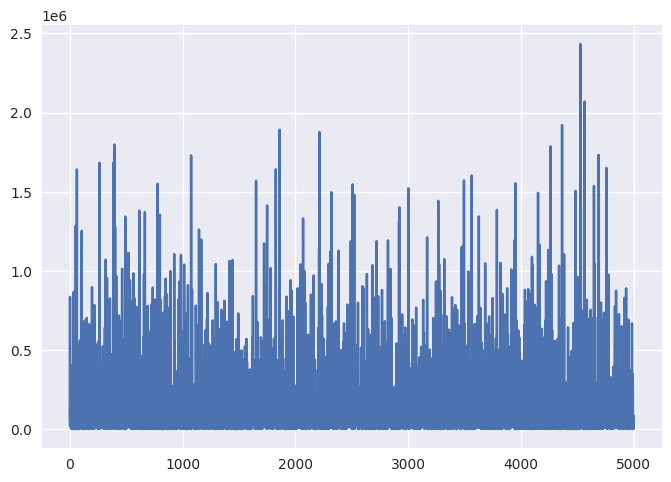

In [46]:
plt.plot(losses)

In [57]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

m = nn.PyroModule("m")
m.w = nn.PyroSample(dist.Normal(0, 10.))
print(m.w.data)

def linear_reg_module_model(data):
    pyro.module("m", m)
    print(m.w)
    with pyro.plate("data", len(data['x'])):
        mu = m.w * data["x"]
        sub_data = pyro.sample("yhat", dist.Normal(mu, 
                                                   torch.tensor(1.)), 
                               obs=data["y"]
                               )
    return sub_data
opt = optim.Adam({"lr": 1e-3})
svi = SVI(linear_reg_module_model, 
          infer.autoguide.AutoNormal(linear_reg_module_model), 
          opt, 
          Trace_ELBO()
          )

losses = []
for i in range(5):
    losses.append(svi.step(data))

tensor(15.4100)
tensor(-2.9343)
tensor(5.6843)
tensor(-13.9860)
tensor(8.3803)
tensor(-4.0334)
tensor(1.8204)


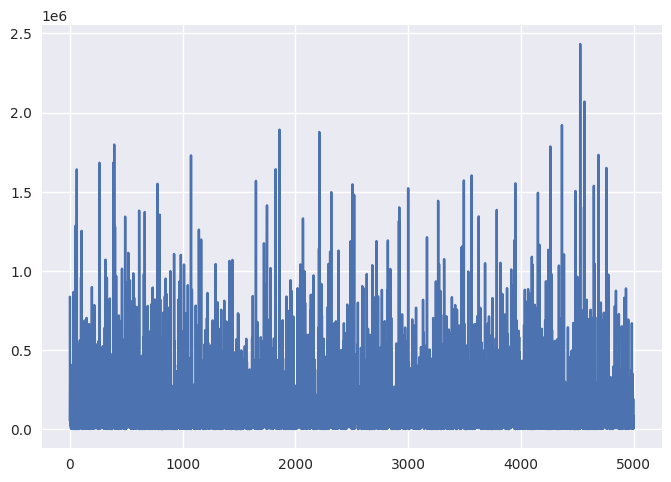

In [52]:
plt.plot(losses)

In [77]:
list(m.parameters())

[]

In [61]:
pyro.clear_param_store()
m = nn.PyroModule()
m.w = nn.PyroSample(dist.Normal(0, 10.))
list(param_store.keys())

[]

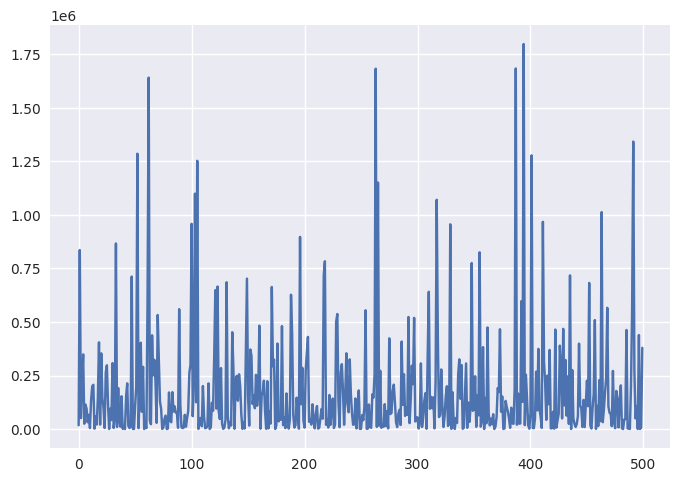

In [62]:
pyro.clear_param_store()
pyro.set_rng_seed(0)

m = nn.PyroModule("m")

def linear_reg_module_model(data):
    pyro.module("m", m)
    m.w = nn.PyroSample(dist.Normal(0, 10.))
    with pyro.plate("data", len(data['x'])):
        mu = m.w * data["x"]
        sub_data = pyro.sample("yhat", dist.Normal(mu, 
                                                   torch.tensor(1.)), 
                               obs=data["y"]
                               )
    return sub_data
opt = optim.Adam({"lr": 1e-3})
svi = SVI(linear_reg_module_model, 
          infer.autoguide.AutoNormal(linear_reg_module_model), 
          opt, 
          Trace_ELBO()
          )

losses = []
for i in range(500):
    losses.append(svi.step(data))

plt.plot(losses)

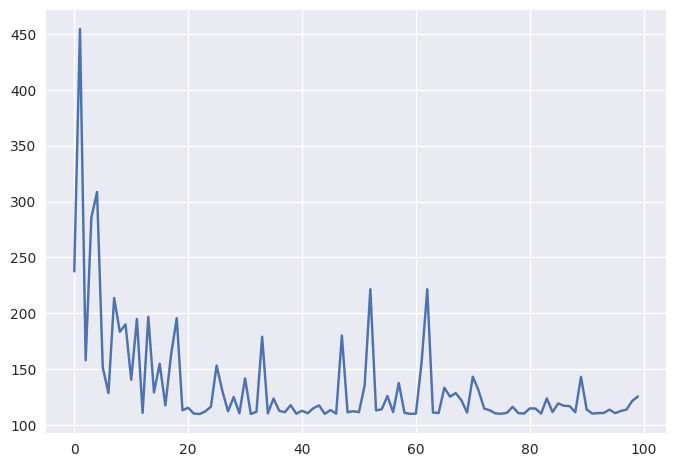

In [10]:
pyro.clear_param_store()
pyro.set_rng_seed(0)


class RegModel(pyro.nn.PyroModule):
    
    def __init__(self,):
        super().__init__()
        self.w =  nn.PyroSample(dist.Normal(0, 10.))
    
    def forward(self, data):
        mu = self.w * data["x"]
        with pyro.plate("data", len(data['x'])):
            sub_data = pyro.sample("yhat", dist.Normal(mu, 
                                                    torch.tensor(1.)), 
                                obs=data["y"]
                                )
        return sub_data



reg = RegModel()
opt = optim.Adam({"lr": 1e-2})
svi = SVI(reg, 
          infer.autoguide.AutoNormal(reg), 
          opt, 
          Trace_ELBO()
          )

losses = []
for i in range(100):
    losses.append(svi.step(data))
    
plt.plot(losses)


In [32]:
list(param_store.keys())

['AutoNormal.locs.w', 'AutoNormal.scales.w']

In [33]:
list(param_store.items())

[('AutoNormal.locs.w',
  Parameter containing:
  tensor(0.2471, requires_grad=True)),
 ('AutoNormal.scales.w', tensor(0.0700, grad_fn=<SoftplusBackward0>))]

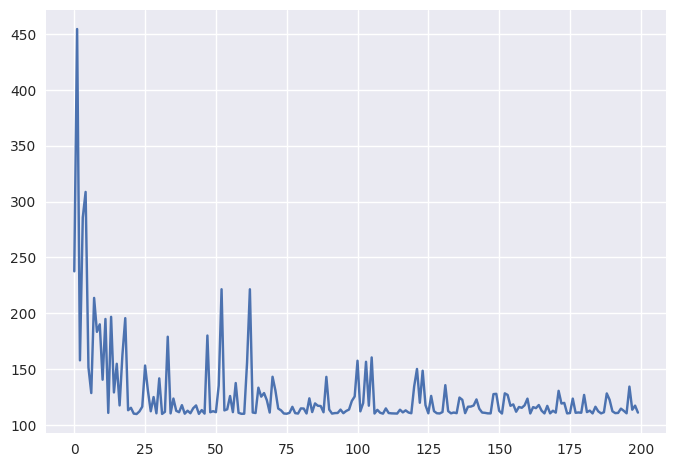

In [14]:
pyro.clear_param_store()
pyro.set_rng_seed(0)


class RegModel(pyro.nn.PyroModule):
    
    def __init__(self,):
        super().__init__()
    
    def forward(self, data):
        mu = self.w * data["x"]
        with pyro.plate("data", len(data['x'])):
            sub_data = pyro.sample("yhat", dist.Normal(mu, 
                                                    torch.tensor(1.)), 
                                obs=data["y"]
                                )
        return sub_data


reg = RegModel()
reg.w =  nn.PyroSample(dist.Normal(0, 10.))
opt = optim.Adam({"lr": 1e-2})
svi = SVI(reg, 
          infer.autoguide.AutoNormal(reg), 
          opt, 
          Trace_ELBO()
          )

losses = []
for i in range(200):
    losses.append(svi.step(data))
    
plt.plot(losses)



In [37]:
list(param_store.items())

[('AutoNormal.locs.w',
  Parameter containing:
  tensor(0.2494, requires_grad=True)),
 ('AutoNormal.scales.w', tensor(0.0230, grad_fn=<SoftplusBackward0>))]

Parameter containing:
tensor([1.5410], requires_grad=True) tensor([0.2934], grad_fn=<AddBackward0>)


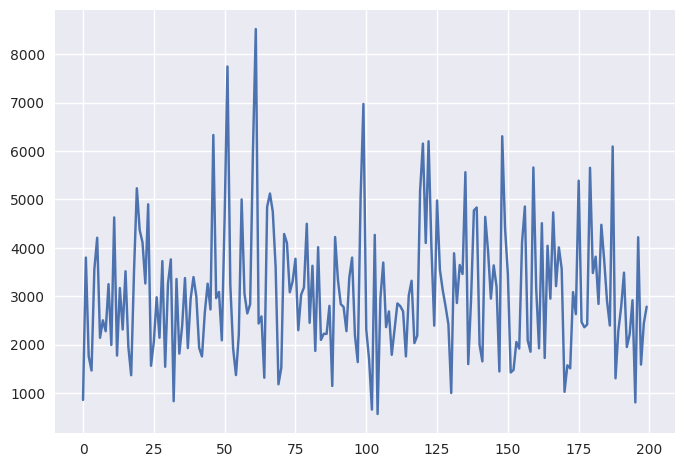

In [25]:
pyro.clear_param_store()
pyro.set_rng_seed(0)


class RegModel(pyro.nn.PyroModule):
    
    def __init__(self,):
        super().__init__()
        self.loc = nn.PyroParam(torch.randn(1))
        self.scale = nn.PyroParam(torch.randn(1).abs(), constraint=pyro.distributions.constraints.positive)
        self.w =  nn.PyroSample(dist.Normal(self.loc, self.scale))
        print(self.loc, self.scale)
        
    def forward(self, data):
        mu = self.w * data["x"]
        with pyro.plate("data", len(data['x'])):
            sub_data = pyro.sample("yhat", dist.Normal(mu, 
                                                    torch.tensor(1.)), 
                                obs=data["y"]
                                )
        return sub_data


reg = RegModel()
opt = optim.Adam({"lr": 1e-2})
svi = SVI(reg, 
          lambda d: None, 
          opt, 
          Trace_ELBO()
          )

losses = []
for i in range(200):
    losses.append(svi.step(data))
    
plt.plot(losses)



In [26]:
reg.scale

tensor([0.2934], grad_fn=<AddBackward0>)

In [29]:
reg.w

tensor([1.1787], grad_fn=<AddBackward0>)

In [31]:
reg.w

tensor([1.0844], grad_fn=<AddBackward0>)

In [27]:
list(param_store.keys())

[]

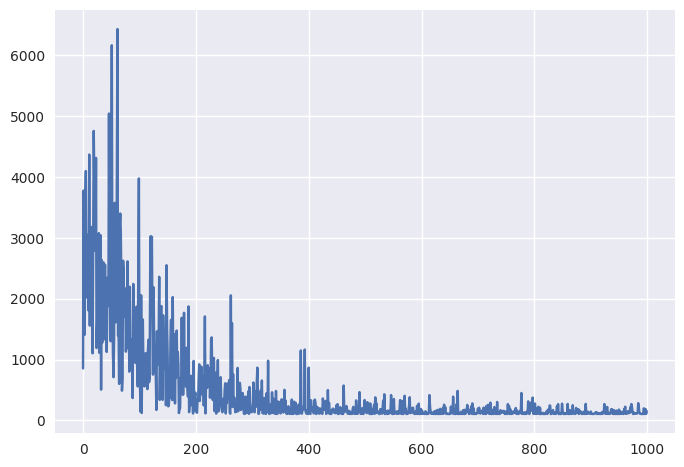

In [24]:
pyro.clear_param_store()
pyro.set_rng_seed(0)


class RegModel(pyro.nn.PyroModule):
    
    def __init__(self,):
        super().__init__()
        self.loc = nn.PyroParam(torch.randn(1))
        self.scale = nn.PyroParam(torch.randn(1).abs(), constraint=pyro.distributions.constraints.positive)

    def forward(self, data):
        self.w = pyro.sample("w", dist.Normal(self.loc, self.scale))
        mu = self.w * data["x"]
        with pyro.plate("data", len(data['x'])):
            sub_data = pyro.sample("yhat", dist.Normal(mu, 
                                                    torch.tensor(1.)), 
                                obs=data["y"]
                                )
        return sub_data



reg = RegModel()
opt = optim.Adam({"lr": 5e-3})
svi = SVI(reg, 
          lambda d: None, 
          opt, 
          Trace_ELBO()
          )

losses = []
for i in range(1000):
    losses.append(svi.step(data))
    
plt.plot(losses)



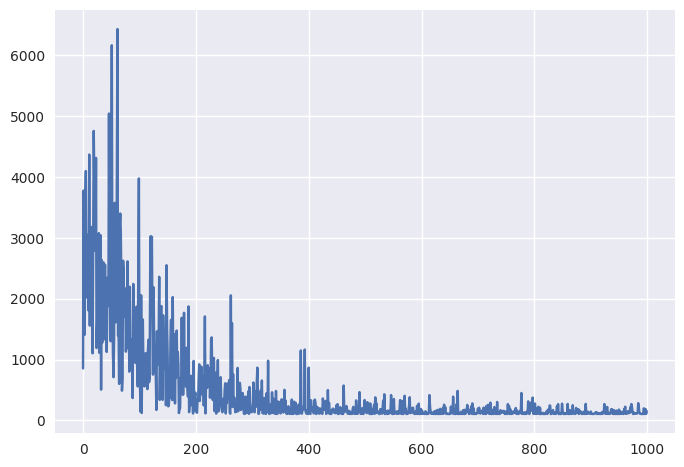

In [35]:
pyro.clear_param_store()
pyro.set_rng_seed(0)


class RegModel(pyro.nn.PyroModule):
    
    def __init__(self,):
        super().__init__()
        self.loc = nn.PyroParam(torch.randn(1))
        self.scale = nn.PyroParam(torch.randn(1).abs(), constraint=pyro.distributions.constraints.positive)
        self.w = nn.PyroSample(lambda self: dist.Normal(self.loc, self.scale))

    def forward(self, data):
        mu = self.w * data["x"]
        with pyro.plate("data", len(data['x'])):
            sub_data = pyro.sample("yhat", dist.Normal(mu, 
                                                    torch.tensor(1.)), 
                                obs=data["y"]
                                )
        return sub_data



reg = RegModel()
opt = optim.Adam({"lr": 5e-3})
svi = SVI(reg, 
          lambda d: None, 
          opt, 
          Trace_ELBO()
          )

losses = []
for i in range(1000):
    losses.append(svi.step(data))
    
plt.plot(losses)



In [38]:
reg.loc, reg.scale

(Parameter containing:
 tensor([0.2449], requires_grad=True),
 tensor([0.1230], grad_fn=<AddBackward0>))

In [39]:
list(param_store.keys())

['loc', 'scale']